## Customer Segmentation using RFM Analysis
This notebook performs customer-level segmentation using Recency, Frequency, and Monetary analysis.


In [1]:
import pandas as pd
import numpy as np

# Load raw dataset
df = pd.read_csv("../data/raw/superstore.csv")

# Drop non-analytical columns
cols_to_drop = ["记录数", "Row.ID", "Customer.Name", "Product.Name", "Market2"]
df = df.drop(columns=cols_to_drop)

# Rename columns
df = df.rename(columns={
    "Customer.ID": "customer_id",
    "Order.ID": "order_id",
    "Order.Date": "order_date",
    "Ship.Date": "ship_date",
    "Product.ID": "product_id",
    "Sub.Category": "sub_category"
})

# Convert order date
df["order_date"] = pd.to_datetime(df["order_date"])

df.head()


,Category,City,Country,customer_id,Discount,Market,order_date,order_id,Order.Priority,product_id,...,Region,Sales,Segment,ship_date,Ship.Mode,Shipping.Cost,State,sub_category,Year,weeknum
0,Office Supplies,Los Angeles,United States,LS-172304,0.0,US,2011-01-07,CA-2011-130813,High,OFF-PA-10002005,...,West,19,Consumer,2011-01-09 00:00:00.000,Second Class,4.37,California,Paper,2011,2
1,Office Supplies,Los Angeles,United States,MV-174854,0.0,US,2011-01-21,CA-2011-148614,Medium,OFF-PA-10002893,...,West,19,Consumer,2011-01-26 00:00:00.000,Standard Class,0.94,California,Paper,2011,4
2,Office Supplies,Los Angeles,United States,CS-121304,0.0,US,2011-08-05,CA-2011-118962,Medium,OFF-PA-10000659,...,West,21,Consumer,2011-08-09 00:00:00.000,Standard Class,1.81,California,Paper,2011,32
3,Office Supplies,Los Angeles,United States,CS-121304,0.0,US,2011-08-05,CA-2011-118962,Medium,OFF-PA-10001144,...,West,111,Consumer,2011-08-09 00:00:00.000,Standard Class,4.59,California,Paper,2011,32
4,Office Supplies,Los Angeles,United States,AP-109154,0.0,US,2011-09-29,CA-2011-146969,High,OFF-PA-10002105,...,West,6,Consumer,2011-10-03 00:00:00.000,Standard Class,1.32,California,Paper,2011,40


## Defining Snapshot Date
Snapshot date is the reference point for calculating customer recency.


In [2]:
snapshot_date = df["order_date"].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2015-01-01 00:00:00')

## RFM Metrics Calculation
Calculating Recency, Frequency, and Monetary value for each customer.


In [3]:
rfm = (
    df
    .groupby("customer_id")
    .agg({
        "order_date": lambda x: (snapshot_date - x.max()).days,
        "order_id": "nunique",
        "Sales": "sum"
    })
    .reset_index()
)

rfm.columns = ["customer_id", "Recency", "Frequency", "Monetary"]

rfm.head()


,customer_id,Recency,Frequency,Monetary
0,AA-103151,9,5,1445
1,AA-103152,14,7,6105
2,AA-103153,695,2,633
3,AA-103154,185,5,5565
4,AA-103751,7,4,2407


In [4]:
rfm.describe()



,Recency,Frequency,Monetary
count,4873.000000,4873.000000,4873.000000
mean,207.422943,5.284835,2594.480813
std,254.526205,2.857330,2465.921576
min,1.000000,1.000000,2.000000
25%,42.000000,3.000000,728.000000
50%,110.000000,5.000000,1894.000000
75%,269.000000,7.000000,3763.000000
max,1460.000000,18.000000,25042.000000


## RFM Scoring
Assigning quartile-based scores.


In [5]:
rfm["R_score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_score"] = pd.qcut(rfm["Frequency"], 4, labels=[1, 2, 3, 4])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])

rfm["RFM_Score"] = (
    rfm["R_score"].astype(str) +
    rfm["F_score"].astype(str) +
    rfm["M_score"].astype(str)
)

rfm.head()


,customer_id,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,AA-103151,9,5,1445,4,2,2,422
1,AA-103152,14,7,6105,4,3,4,434
2,AA-103153,695,2,633,1,1,1,111
3,AA-103154,185,5,5565,2,2,4,224
4,AA-103751,7,4,2407,4,2,3,423


## Customer Segmentation
High-level business-friendly segments.


In [6]:
def label_segment(score):
    if score >= "444":
        return "High Value"
    elif score >= "333":
        return "Medium Value"
    else:
        return "Low Value"

rfm["Customer_Segment"] = rfm["RFM_Score"].apply(label_segment)
rfm["Customer_Segment"].value_counts()


Customer_Segment
Low Value       3016
Medium Value    1586
High Value       271
Name: count, dtype: int64

In [7]:
segment_summary = (
    rfm
    .groupby("Customer_Segment")
    .agg(
        Customers=("customer_id", "nunique"),
        Avg_Recency=("Recency", "mean"),
        Avg_Frequency=("Frequency", "mean"),
        Avg_Monetary=("Monetary", "mean")
    )
    .sort_values(by="Avg_Monetary", ascending=False)
)

segment_summary


,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary
Customer_Segment,,,,
High Value,271,19.428044,9.900369,6437.867159
Medium Value,1586,40.242749,6.656999,3236.454603
Low Value,3016,312.228780,4.148541,1911.547082


### RFM Insights
- High Value customers purchase more frequently and contribute the highest monetary value.
- Medium Value customers show growth potential with targeted campaigns.
- Low Value customers are infrequent buyers with low spend.


## K-Means Clustering Preparation
Scaling RFM features before clustering.


In [9]:
from sklearn.preprocessing import StandardScaler


rfm_features = rfm[["Recency", "Frequency", "Monetary"]]


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

rfm_scaled[:5]


array([[-0.77965766, -0.09969587, -0.46619438],
       [-0.7600113 ,  0.60033002,  1.42375957],
       [ 1.91582275, -1.14973471, -0.79551683],
       [-0.08810584, -0.09969587,  1.20475203],
       [-0.7875162 , -0.44970881, -0.0760365 ]])

## Elbow Method
Determining the optimal number of clusters.


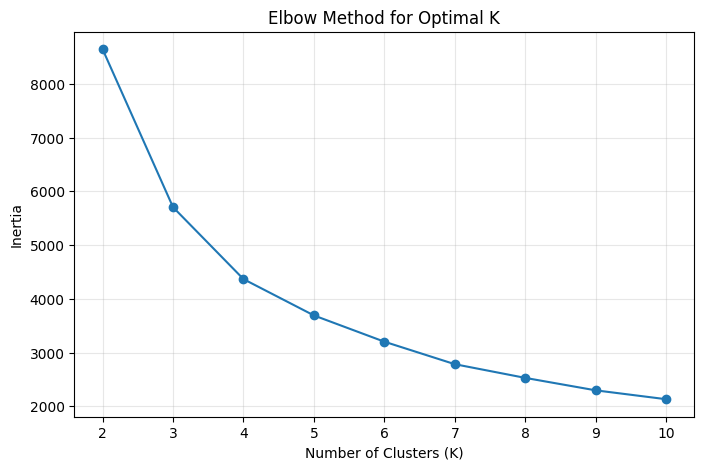

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(alpha=0.3)
plt.show()


## Applying K-Means Clustering (K = 3)
Based on the elbow method, K = 3 is selected for customer segmentation.


In [11]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,customer_id,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Customer_Segment,Cluster
0,AA-103151,9,5,1445,4,2,2,422,Medium Value,0
1,AA-103152,14,7,6105,4,3,4,434,Medium Value,1
2,AA-103153,695,2,633,1,1,1,111,Low Value,2
3,AA-103154,185,5,5565,2,2,4,224,Low Value,1
4,AA-103751,7,4,2407,4,2,3,423,Medium Value,0


## Cluster Profiling
Understanding characteristics of each cluster.


In [12]:
cluster_profile = (
    rfm
    .groupby("Cluster")
    .agg(
        Customers=("customer_id", "nunique"),
        Avg_Recency=("Recency", "mean"),
        Avg_Frequency=("Frequency", "mean"),
        Avg_Monetary=("Monetary", "mean")
    )
    .sort_values(by="Avg_Monetary", ascending=False)
)

cluster_profile


,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary
Cluster,,,,
1,1573,95.092181,8.348379,5201.420852
0,2659,144.408800,4.232042,1492.176006
2,641,744.475819,2.134165,769.694228


## Cluster Labeling
Assigning business-friendly labels to clusters.


In [13]:
cluster_labels = {
    1: "High Value",
    0: "Medium Value",
    2: "Low Value"
}

rfm["Cluster_Label"] = rfm["Cluster"].map(cluster_labels)

rfm["Cluster_Label"].value_counts()


Cluster_Label
Medium Value    2659
High Value      1573
Low Value        641
Name: count, dtype: int64

In [14]:
pd.crosstab(rfm["Customer_Segment"], rfm["Cluster_Label"])


Cluster_Label,High Value,Low Value,Medium Value
Customer_Segment,,,
High Value,271,0,0
Low Value,487,641,1888
Medium Value,815,0,771


## Merge Customer Segments with Transaction Data
Preparing final dataset for Power BI.


In [15]:
final_df = df.merge(
    rfm[["customer_id", "Cluster_Label"]],
    on="customer_id",
    how="left"
)

final_df.head()


,Category,City,Country,customer_id,Discount,Market,order_date,order_id,Order.Priority,product_id,...,Sales,Segment,ship_date,Ship.Mode,Shipping.Cost,State,sub_category,Year,weeknum,Cluster_Label
0,Office Supplies,Los Angeles,United States,LS-172304,0.0,US,2011-01-07,CA-2011-130813,High,OFF-PA-10002005,...,19,Consumer,2011-01-09 00:00:00.000,Second Class,4.37,California,Paper,2011,2,Low Value
1,Office Supplies,Los Angeles,United States,MV-174854,0.0,US,2011-01-21,CA-2011-148614,Medium,OFF-PA-10002893,...,19,Consumer,2011-01-26 00:00:00.000,Standard Class,0.94,California,Paper,2011,4,High Value
2,Office Supplies,Los Angeles,United States,CS-121304,0.0,US,2011-08-05,CA-2011-118962,Medium,OFF-PA-10000659,...,21,Consumer,2011-08-09 00:00:00.000,Standard Class,1.81,California,Paper,2011,32,Low Value
3,Office Supplies,Los Angeles,United States,CS-121304,0.0,US,2011-08-05,CA-2011-118962,Medium,OFF-PA-10001144,...,111,Consumer,2011-08-09 00:00:00.000,Standard Class,4.59,California,Paper,2011,32,Low Value
4,Office Supplies,Los Angeles,United States,AP-109154,0.0,US,2011-09-29,CA-2011-146969,High,OFF-PA-10002105,...,6,Consumer,2011-10-03 00:00:00.000,Standard Class,1.32,California,Paper,2011,40,High Value


## Export Final Dataset


In [17]:
final_df.to_csv("../data/final_retail_sales_with_segments.csv", index=False)
